In [ ]:
!pip install -U albumentations
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import cv2
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2


import glob
from tqdm import tqdm


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time



In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Vision')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data_path = 'Data/Train/'
test_data_path = 'Data/Test/'

train_image_paths = [] 
classes = [] 


for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])



#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nTest size: {}".format(len(train_image_paths), len(test_image_paths)))

train_image_path example:  Data/Train/Office/image_0131.jpg
class example:  Tall_Building
Train size: 2985
Test size: 1500


In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [ ]:


train_transforms = A.Compose(
    [
        A.Resize(height=227, width=227),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=False, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(height=227, width=227),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
trainset = LandmarkDataset(train_image_paths,train_transforms)
valset = LandmarkDataset(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',trainset[49][0].shape)
print('The label for 50th image in train dataset: ',valset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 227, 227])
The label for 50th image in train dataset:  0


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(
    trainset, batch_size=256, shuffle=True,num_workers=2
)


valloader = DataLoader(
    valset, batch_size=1024, shuffle=False,num_workers=2
)

testloader = valloader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import torchvision
from torchvision import transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

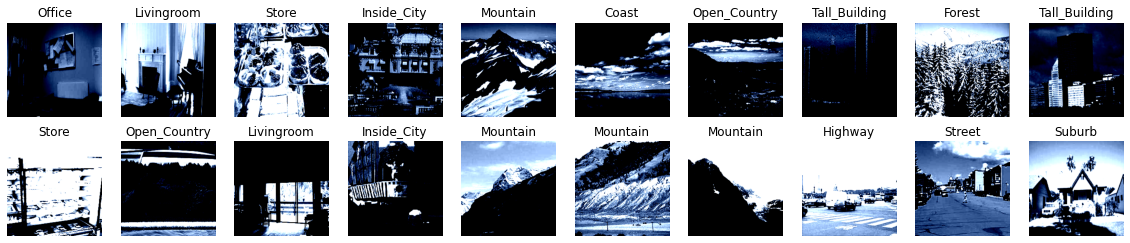

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 4))

for i in range(20):
    fig.add_subplot(2, 10, i + 1)
    image, label = trainset[i]
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(classes[label])
    plt.axis('off')

plt.show()

In [ ]:

def train_epoch(net: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, dataloader: torch.utils.data.DataLoader,   accs_train ,loss_train):

    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    # Set model to training mode
    net.train()

    # zero the parameter gradients
    optimizer.zero_grad()

    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar: 

            # Transfer data to device
            x = x.to(device)  
            y = y.to(device)

            # forward
            p = net(x)

            # loss eval
            loss = criterion(p, y)
            epoch_loss += float(loss)

            # predict 
            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()
            
            # Computes accuracy and loss
            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')


            # Backward the error
            loss.backward()
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()
          
        accs_train.append(float(epoch_true / epoch_all))
        loss_train.append(float(epoch_loss / (i + 1)))
    return accs_train,loss_train

def eval_epoch(net: nn.Module, criterion: nn.Module, dataloader: torch.utils.data.DataLoader,    accs_test ,loss_test ):

    epoch_loss = 0
    epoch_true = 0
    epoch_true_topfive = 0
    epoch_all = 0
    i = 0

    # Set model to evaluate mode
    net.eval()

    with torch.no_grad(), tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:

            # Transfer data to device
            x = x.to(device)
            y = y.to(device)

            # forward
            p = net(x)

            # loss eval
            loss = criterion(p, y)
            epoch_loss += float(loss)

            # predict 
            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}% ')

        accs_test.append(float(epoch_true / epoch_all))
        loss_test.append(float(epoch_loss / (i + 1)))
    return accs_test,loss_test


Loss: 2.475e+00 - Acc: 15.20% : 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


Epoch   1 finished in 32.43s


Loss: 2.141e+00 - Acc: 30.80% : 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch   2 finished in 25.35s


Loss: 2.010e+00 - Acc: 38.13% : 100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


Epoch   3 finished in 23.99s


Loss: 1.887e+00 - Acc: 42.40% : 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch   4 finished in 24.00s


Loss: 1.719e+00 - Acc: 46.13% : 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch   5 finished in 26.40s


Loss: 1.693e+00 - Acc: 47.27% : 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch   6 finished in 24.26s


Loss: 1.778e+00 - Acc: 46.40% : 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch   7 finished in 24.04s


Loss: 1.638e+00 - Acc: 52.00% : 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch   8 finished in 25.19s


Loss: 1.623e+00 - Acc: 51.73% : 100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


Epoch   9 finished in 24.29s


Loss: 1.634e+00 - Acc: 51.80% : 100%|██████████| 2/2 [00:08<00:00,  4.28s/it]

Epoch  10 finished in 24.62s



Loss: 1.430e+00 - Acc: 53.53% : 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch  11 finished in 24.93s


Loss: 1.463e+00 - Acc: 55.87% : 100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


Epoch  12 finished in 24.08s


Loss: 1.549e+00 - Acc: 56.40% : 100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Epoch  13 finished in 24.96s


Loss: 1.411e+00 - Acc: 57.67% : 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch  14 finished in 24.05s


Loss: 1.381e+00 - Acc: 58.47% : 100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


Epoch  15 finished in 24.26s


Loss: 1.389e+00 - Acc: 59.00% : 100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


Epoch  16 finished in 25.43s


Loss: 1.427e+00 - Acc: 58.47% : 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch  17 finished in 24.15s


Loss: 1.474e+00 - Acc: 59.80% : 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch  18 finished in 24.35s


Loss: 1.522e+00 - Acc: 58.53% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  19 finished in 24.97s


Loss: 1.424e+00 - Acc: 58.87% : 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch  20 finished in 23.77s


Loss: 1.642e+00 - Acc: 59.53% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  21 finished in 24.28s


Loss: 1.509e+00 - Acc: 59.27% : 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch  22 finished in 25.00s


Loss: 1.446e+00 - Acc: 60.73% : 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch  23 finished in 23.93s


Loss: 1.413e+00 - Acc: 61.20% : 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch  24 finished in 23.95s


Loss: 1.506e+00 - Acc: 59.07% : 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch  25 finished in 24.74s


Loss: 1.478e+00 - Acc: 59.93% : 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch  26 finished in 23.96s


Loss: 1.570e+00 - Acc: 59.60% : 100%|██████████| 2/2 [00:07<00:00,  4.00s/it]


Epoch  27 finished in 23.89s


Loss: 1.487e+00 - Acc: 61.07% : 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch  28 finished in 24.97s


Loss: 1.575e+00 - Acc: 61.20% : 100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


Epoch  29 finished in 23.79s


Loss: 1.490e+00 - Acc: 61.47% : 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch  30 finished in 23.72s


Loss: 1.691e+00 - Acc: 60.33% : 100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


Epoch  31 finished in 24.79s


Loss: 1.550e+00 - Acc: 62.27% : 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Epoch  32 finished in 23.84s


Loss: 1.740e+00 - Acc: 60.47% : 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]


Epoch  33 finished in 23.88s


Loss: 1.722e+00 - Acc: 60.33% : 100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


Epoch  34 finished in 25.19s


Loss: 1.538e+00 - Acc: 61.67% : 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


Epoch  35 finished in 23.50s


Loss: 1.675e+00 - Acc: 62.00% : 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch  36 finished in 24.43s


Loss: 1.855e+00 - Acc: 60.60% : 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch  37 finished in 23.96s


Loss: 1.867e+00 - Acc: 59.20% : 100%|██████████| 2/2 [00:07<00:00,  3.99s/it]


Epoch  38 finished in 23.82s


Loss: 1.659e+00 - Acc: 60.27% : 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]


Epoch  39 finished in 24.33s


Loss: 1.718e+00 - Acc: 61.33% : 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Epoch  40 finished in 23.78s


Loss: 1.662e+00 - Acc: 62.13% : 100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


Epoch  41 finished in 23.72s


Loss: 1.667e+00 - Acc: 62.33% : 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


Epoch  42 finished in 24.99s


Loss: 1.827e+00 - Acc: 61.87% : 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


Epoch  43 finished in 23.90s


Loss: 1.721e+00 - Acc: 61.27% : 100%|██████████| 2/2 [00:08<00:00,  4.01s/it]


Epoch  44 finished in 23.71s


Loss: 1.757e+00 - Acc: 62.00% : 100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Epoch  45 finished in 24.89s


Loss: 1.771e+00 - Acc: 62.40% : 100%|██████████| 2/2 [00:08<00:00,  4.05s/it]


Epoch  46 finished in 24.08s


Loss: 1.764e+00 - Acc: 61.80% : 100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


Epoch  47 finished in 24.13s


Loss: 1.796e+00 - Acc: 62.00% : 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Epoch  48 finished in 24.83s


Loss: 1.850e+00 - Acc: 63.40% : 100%|██████████| 2/2 [00:07<00:00,  3.98s/it]


Epoch  49 finished in 23.57s


Loss: 1.904e+00 - Acc: 63.00% : 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]


Epoch  50 finished in 23.53s


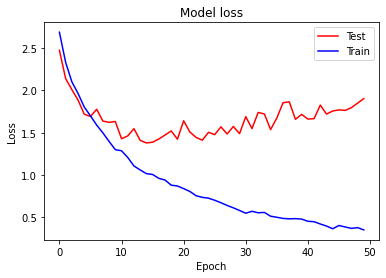

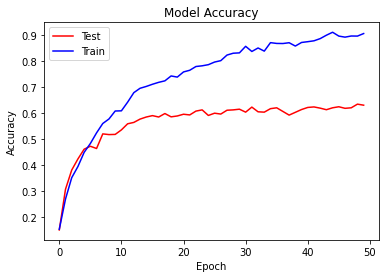

Best Accuracy:63.40%


In [ ]:


class AlexNet1(nn.Module):
    def __init__(self, num_classes: int = 15, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=4),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(12544, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet1().to(device)
net

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)


epochs = 50
from time import time
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(epochs):
    start_time = time()
    accs_train,loss_train = train_epoch(net, criterion, optimizer, trainloader,accs_train,loss_train)
    accs_test,loss_test = eval_epoch(net, criterion, valloader,accs_test,loss_test)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

plt.plot(np.array(loss_test), 'r')
plt.plot(np.array(loss_train), 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss1.jpg')
plt.show()

plt.plot(np.array(accs_test), 'r')
plt.plot(np.array(accs_train), 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc1.jpg')
plt.show()

torch.save(net.state_dict(), 'alexNet1.pth')
print(f'Best Accuracy:{max(accs_test) * 100.:.2f}%')


Loss: 2.714e+00 - Acc: 9.67% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch   1 finished in 29.02s


Loss: 2.510e+00 - Acc: 16.80% : 100%|██████████| 2/2 [00:09<00:00,  4.76s/it]


Epoch   2 finished in 26.88s


Loss: 2.130e+00 - Acc: 30.67% : 100%|██████████| 2/2 [00:09<00:00,  4.62s/it]


Epoch   3 finished in 25.56s


Loss: 2.093e+00 - Acc: 33.87% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch   4 finished in 26.35s


Loss: 1.851e+00 - Acc: 38.53% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch   5 finished in 24.83s


Loss: 1.684e+00 - Acc: 41.67% : 100%|██████████| 2/2 [00:08<00:00,  4.47s/it]


Epoch   6 finished in 25.52s


Loss: 1.634e+00 - Acc: 46.47% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch   7 finished in 24.79s


Loss: 1.557e+00 - Acc: 48.53% : 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch   8 finished in 24.81s


Loss: 1.554e+00 - Acc: 50.13% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch   9 finished in 26.40s


Loss: 1.443e+00 - Acc: 51.60% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  10 finished in 25.50s


Loss: 1.447e+00 - Acc: 53.87% : 100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Epoch  11 finished in 25.56s


Loss: 1.359e+00 - Acc: 54.67% : 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch  12 finished in 24.57s


Loss: 1.288e+00 - Acc: 58.13% : 100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Epoch  13 finished in 24.54s


Loss: 1.323e+00 - Acc: 57.80% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  14 finished in 26.11s


Loss: 1.358e+00 - Acc: 60.20% : 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch  15 finished in 24.80s


Loss: 1.414e+00 - Acc: 57.00% : 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


Epoch  16 finished in 25.74s


Loss: 1.263e+00 - Acc: 58.13% : 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


Epoch  17 finished in 25.16s


Loss: 1.144e+00 - Acc: 61.53% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch  18 finished in 24.83s


Loss: 1.186e+00 - Acc: 63.07% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  19 finished in 25.82s


Loss: 1.166e+00 - Acc: 62.47% : 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch  20 finished in 24.44s


Loss: 1.129e+00 - Acc: 63.33% : 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


Epoch  21 finished in 25.94s


Loss: 1.093e+00 - Acc: 63.47% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  22 finished in 24.59s


Loss: 1.145e+00 - Acc: 65.53% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  23 finished in 24.70s


Loss: 1.163e+00 - Acc: 64.93% : 100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Epoch  24 finished in 25.86s


Loss: 1.174e+00 - Acc: 65.67% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  25 finished in 24.45s


Loss: 1.094e+00 - Acc: 66.33% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  26 finished in 24.94s


Loss: 1.302e+00 - Acc: 64.80% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  27 finished in 25.76s


Loss: 1.185e+00 - Acc: 66.13% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  28 finished in 24.61s


Loss: 1.124e+00 - Acc: 66.20% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  29 finished in 25.67s


Loss: 1.155e+00 - Acc: 65.73% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  30 finished in 24.66s


Loss: 1.085e+00 - Acc: 67.13% : 100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


Epoch  31 finished in 24.38s


Loss: 1.084e+00 - Acc: 67.13% : 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch  32 finished in 25.71s


Loss: 1.130e+00 - Acc: 68.40% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  33 finished in 24.28s


Loss: 1.160e+00 - Acc: 68.07% : 100%|██████████| 2/2 [00:08<00:00,  4.36s/it]


Epoch  34 finished in 25.80s


Loss: 1.198e+00 - Acc: 66.80% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  35 finished in 24.14s


Loss: 1.236e+00 - Acc: 66.47% : 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch  36 finished in 24.22s


Loss: 1.207e+00 - Acc: 65.93% : 100%|██████████| 2/2 [00:08<00:00,  4.10s/it]


Epoch  37 finished in 25.81s


Loss: 1.143e+00 - Acc: 67.00% : 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch  38 finished in 24.67s


Loss: 1.100e+00 - Acc: 66.73% : 100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Epoch  39 finished in 25.83s


Loss: 1.217e+00 - Acc: 67.60% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  40 finished in 24.47s


Loss: 1.319e+00 - Acc: 65.60% : 100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Epoch  41 finished in 24.69s


Loss: 1.231e+00 - Acc: 67.13% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  42 finished in 25.71s


Loss: 1.200e+00 - Acc: 68.53% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  43 finished in 23.95s


Loss: 1.299e+00 - Acc: 67.07% : 100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Epoch  44 finished in 25.44s


Loss: 1.388e+00 - Acc: 67.40% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  45 finished in 24.38s


Loss: 1.298e+00 - Acc: 67.53% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  46 finished in 25.38s


Loss: 1.239e+00 - Acc: 67.53% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  47 finished in 25.66s


Loss: 1.291e+00 - Acc: 68.33% : 100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


Epoch  48 finished in 24.61s


Loss: 1.226e+00 - Acc: 69.27% : 100%|██████████| 2/2 [00:09<00:00,  4.53s/it]


Epoch  49 finished in 25.28s


Loss: 1.339e+00 - Acc: 68.20% : 100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Epoch  50 finished in 24.50s


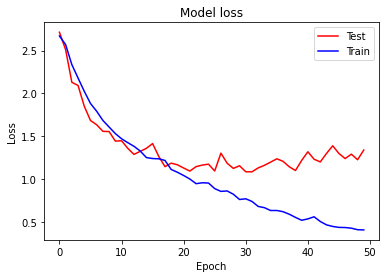

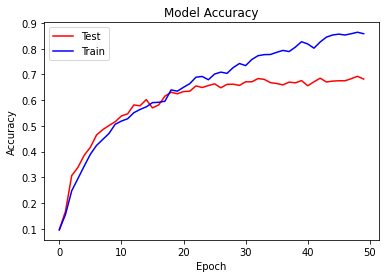

Best Accuracy:69.27%


In [ ]:

class AlexNet2(nn.Module):
    def __init__(self, num_classes: int = 15, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet2().to(device)
net

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

epochs = 50
from time import time
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(epochs):
    start_time = time()
    accs_train,loss_train = train_epoch(net, criterion, optimizer, trainloader,accs_train,loss_train)
    accs_test,loss_test = eval_epoch(net, criterion, valloader,accs_test,loss_test)
    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

plt.plot(np.array(loss_test), 'r')
plt.plot(np.array(loss_train), 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss2.jpg')
plt.show()

plt.plot(np.array(accs_test), 'r')
plt.plot(np.array(accs_train), 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc2.jpg')
plt.show()

torch.save(net.state_dict(), 'alexNet2.pth')
print(f'Best Accuracy:{max(accs_test) * 100.:.2f}%')

Loss: 2.699e+00 - Acc: 8.53% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch   1 finished in 31.78s


Loss: 2.685e+00 - Acc: 11.47% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch   2 finished in 26.40s


Loss: 2.435e+00 - Acc: 20.47% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch   3 finished in 29.89s


Loss: 2.278e+00 - Acc: 22.27% : 100%|██████████| 2/2 [00:09<00:00,  4.99s/it]


Epoch   4 finished in 27.18s


Loss: 2.204e+00 - Acc: 28.40% : 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


Epoch   5 finished in 25.54s


Loss: 1.938e+00 - Acc: 35.07% : 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


Epoch   6 finished in 25.19s


Loss: 1.796e+00 - Acc: 39.33% : 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch   7 finished in 26.33s


Loss: 1.709e+00 - Acc: 41.13% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch   8 finished in 24.84s


Loss: 1.655e+00 - Acc: 43.60% : 100%|██████████| 2/2 [00:09<00:00,  4.81s/it]


Epoch   9 finished in 25.82s


Loss: 1.745e+00 - Acc: 44.60% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  10 finished in 24.77s


Loss: 1.644e+00 - Acc: 44.00% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  11 finished in 24.62s


Loss: 1.608e+00 - Acc: 44.20% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  12 finished in 26.44s


Loss: 1.555e+00 - Acc: 48.07% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch  13 finished in 24.68s


Loss: 1.367e+00 - Acc: 52.67% : 100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Epoch  14 finished in 25.69s


Loss: 1.362e+00 - Acc: 52.53% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  15 finished in 25.01s


Loss: 1.382e+00 - Acc: 53.67% : 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


Epoch  16 finished in 25.17s


Loss: 1.357e+00 - Acc: 55.87% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  17 finished in 26.37s


Loss: 1.288e+00 - Acc: 57.00% : 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


Epoch  18 finished in 25.32s


Loss: 1.290e+00 - Acc: 57.00% : 100%|██████████| 2/2 [00:09<00:00,  4.77s/it]


Epoch  19 finished in 25.81s


Loss: 1.275e+00 - Acc: 57.33% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  20 finished in 24.85s


Loss: 1.185e+00 - Acc: 61.47% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  21 finished in 24.89s


Loss: 1.386e+00 - Acc: 57.47% : 100%|██████████| 2/2 [00:08<00:00,  4.28s/it]


Epoch  22 finished in 26.09s


Loss: 1.230e+00 - Acc: 59.87% : 100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


Epoch  23 finished in 24.70s


Loss: 1.261e+00 - Acc: 60.27% : 100%|██████████| 2/2 [00:09<00:00,  4.65s/it]


Epoch  24 finished in 25.55s


Loss: 1.195e+00 - Acc: 61.93% : 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


Epoch  25 finished in 25.13s


Loss: 1.228e+00 - Acc: 63.13% : 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


Epoch  26 finished in 25.55s


Loss: 1.219e+00 - Acc: 63.13% : 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch  27 finished in 26.54s


Loss: 1.150e+00 - Acc: 64.33% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  28 finished in 25.08s


Loss: 1.181e+00 - Acc: 64.27% : 100%|██████████| 2/2 [00:09<00:00,  4.67s/it]


Epoch  29 finished in 25.90s


Loss: 1.145e+00 - Acc: 63.07% : 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


Epoch  30 finished in 25.12s


Loss: 1.148e+00 - Acc: 65.20% : 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


Epoch  31 finished in 24.92s


Loss: 1.179e+00 - Acc: 64.80% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  32 finished in 26.29s


Loss: 1.142e+00 - Acc: 65.73% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  33 finished in 24.82s


Loss: 1.151e+00 - Acc: 64.47% : 100%|██████████| 2/2 [00:09<00:00,  4.56s/it]


Epoch  34 finished in 25.58s


Loss: 1.249e+00 - Acc: 63.40% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  35 finished in 25.13s


Loss: 1.261e+00 - Acc: 65.60% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  36 finished in 24.62s


Loss: 1.174e+00 - Acc: 65.60% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  37 finished in 26.45s


Loss: 1.155e+00 - Acc: 68.00% : 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch  38 finished in 24.94s


Loss: 1.132e+00 - Acc: 68.60% : 100%|██████████| 2/2 [00:08<00:00,  4.50s/it]

Epoch  39 finished in 25.41s



Loss: 1.111e+00 - Acc: 68.80% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  40 finished in 25.32s


Loss: 1.333e+00 - Acc: 65.87% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  41 finished in 25.19s


Loss: 1.227e+00 - Acc: 66.07% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  42 finished in 26.27s


Loss: 1.144e+00 - Acc: 68.27% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  43 finished in 25.42s


Loss: 1.113e+00 - Acc: 69.47% : 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


Epoch  44 finished in 24.83s


Loss: 1.251e+00 - Acc: 68.33% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  45 finished in 25.16s


Loss: 1.233e+00 - Acc: 69.07% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  46 finished in 24.91s


Loss: 1.209e+00 - Acc: 68.80% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  47 finished in 25.76s


Loss: 1.264e+00 - Acc: 68.60% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  48 finished in 25.02s


Loss: 1.183e+00 - Acc: 68.00% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  49 finished in 24.84s


Loss: 1.233e+00 - Acc: 68.80% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  50 finished in 25.99s


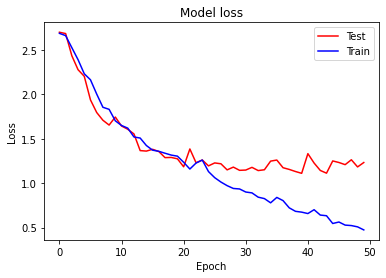

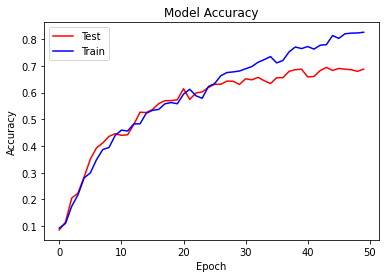

Best Accuracy:69.47%


In [22]:
accs = []
class AlexNet3(nn.Module):
    def __init__(self, num_classes: int = 15, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

net = AlexNet3().to(device)
net

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

epochs = 50
from time import time
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(epochs):
    start_time = time()
    accs_train,loss_train = train_epoch(net, criterion, optimizer, trainloader,accs_train,loss_train)
    accs_test,loss_test = eval_epoch(net, criterion, valloader,accs_test,loss_test)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

plt.plot(np.array(loss_test), 'r')
plt.plot(np.array(loss_train), 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss3.jpg')
plt.show()

plt.plot(np.array(accs_test), 'r')
plt.plot(np.array(accs_train), 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc3.jpg')
plt.show()

torch.save(net.state_dict(), 'alexNet3.pth')
print(f'Best Accuracy:{max(accs_test) * 100.:.2f}%')


In [23]:
import torch
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ["AlexNet", "alexnet"]


model_urls = {
    "alexnet": "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth",
}

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Loss: 2.232e+00 - Acc: 31.60% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch   1 finished in 24.87s


Loss: 1.747e+00 - Acc: 52.93% : 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


Epoch   2 finished in 23.86s


Loss: 1.422e+00 - Acc: 63.87% : 100%|██████████| 2/2 [00:09<00:00,  4.69s/it]


Epoch   3 finished in 25.04s


Loss: 1.191e+00 - Acc: 69.87% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch   4 finished in 24.14s


Loss: 1.034e+00 - Acc: 73.67% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch   5 finished in 23.71s


Loss: 9.311e-01 - Acc: 75.60% : 100%|██████████| 2/2 [00:08<00:00,  4.08s/it]


Epoch   6 finished in 24.94s


Loss: 8.575e-01 - Acc: 76.93% : 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]


Epoch   7 finished in 23.75s


Loss: 7.998e-01 - Acc: 78.53% : 100%|██████████| 2/2 [00:09<00:00,  4.52s/it]


Epoch   8 finished in 24.87s


Loss: 7.479e-01 - Acc: 80.47% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch   9 finished in 24.34s


Loss: 7.049e-01 - Acc: 81.60% : 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch  10 finished in 24.41s


Loss: 6.768e-01 - Acc: 81.93% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  11 finished in 25.58s


Loss: 6.471e-01 - Acc: 82.53% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  12 finished in 24.18s


Loss: 6.260e-01 - Acc: 83.53% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch  13 finished in 24.56s


Loss: 6.031e-01 - Acc: 83.73% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch  14 finished in 26.10s


Loss: 5.885e-01 - Acc: 84.33% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  15 finished in 24.69s


Loss: 5.718e-01 - Acc: 84.33% : 100%|██████████| 2/2 [00:09<00:00,  4.50s/it]


Epoch  16 finished in 25.84s


Loss: 5.664e-01 - Acc: 84.40% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]

Epoch  17 finished in 24.30s



Loss: 5.495e-01 - Acc: 84.60% : 100%|██████████| 2/2 [00:08<00:00,  4.31s/it]


Epoch  18 finished in 24.62s


Loss: 5.380e-01 - Acc: 84.87% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch  19 finished in 25.60s


Loss: 5.248e-01 - Acc: 85.20% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  20 finished in 24.23s


Loss: 5.152e-01 - Acc: 85.40% : 100%|██████████| 2/2 [00:10<00:00,  5.09s/it]


Epoch  21 finished in 26.21s


Loss: 5.006e-01 - Acc: 85.67% : 100%|██████████| 2/2 [00:08<00:00,  4.44s/it]


Epoch  22 finished in 25.58s


Loss: 4.970e-01 - Acc: 85.87% : 100%|██████████| 2/2 [00:08<00:00,  4.32s/it]


Epoch  23 finished in 24.51s


Loss: 4.937e-01 - Acc: 85.93% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  24 finished in 25.62s


Loss: 4.950e-01 - Acc: 85.67% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch  25 finished in 24.29s


Loss: 4.929e-01 - Acc: 85.60% : 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch  26 finished in 25.55s


Loss: 4.824e-01 - Acc: 86.07% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  27 finished in 24.53s


Loss: 4.786e-01 - Acc: 86.00% : 100%|██████████| 2/2 [00:09<00:00,  4.58s/it]


Epoch  28 finished in 24.97s


Loss: 4.717e-01 - Acc: 86.20% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch  29 finished in 24.37s


Loss: 4.714e-01 - Acc: 85.80% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  30 finished in 24.21s


Loss: 4.618e-01 - Acc: 86.40% : 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch  31 finished in 25.50s


Loss: 4.653e-01 - Acc: 86.53% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  32 finished in 24.19s


Loss: 4.621e-01 - Acc: 86.73% : 100%|██████████| 2/2 [00:09<00:00,  4.85s/it]


Epoch  33 finished in 25.66s


Loss: 4.563e-01 - Acc: 86.93% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch  34 finished in 24.52s


Loss: 4.460e-01 - Acc: 87.00% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  35 finished in 24.37s


Loss: 4.408e-01 - Acc: 86.80% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  36 finished in 25.65s


Loss: 4.457e-01 - Acc: 86.60% : 100%|██████████| 2/2 [00:08<00:00,  4.24s/it]


Epoch  37 finished in 24.32s


Loss: 4.398e-01 - Acc: 86.93% : 100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Epoch  38 finished in 25.32s


Loss: 4.441e-01 - Acc: 86.93% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  39 finished in 24.38s


Loss: 4.385e-01 - Acc: 86.87% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  40 finished in 24.40s


Loss: 4.347e-01 - Acc: 87.20% : 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


Epoch  41 finished in 25.82s


Loss: 4.325e-01 - Acc: 87.40% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch  42 finished in 24.05s


Loss: 4.298e-01 - Acc: 87.27% : 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]


Epoch  43 finished in 25.59s


Loss: 4.195e-01 - Acc: 87.47% : 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch  44 finished in 24.29s


Loss: 4.163e-01 - Acc: 87.67% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  45 finished in 24.29s


Loss: 4.187e-01 - Acc: 87.33% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  46 finished in 25.66s


Loss: 4.229e-01 - Acc: 87.20% : 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


Epoch  47 finished in 24.49s


Loss: 4.258e-01 - Acc: 87.33% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch  48 finished in 25.20s


Loss: 4.235e-01 - Acc: 87.20% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]

Epoch  49 finished in 23.90s



Loss: 4.165e-01 - Acc: 87.27% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  50 finished in 24.26s


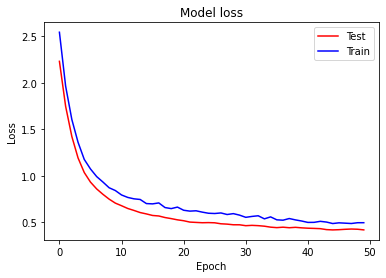

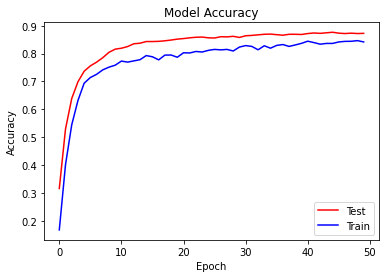

Best Accuracy:87.67%


In [24]:
accs = []
class AlexNet4(nn.Module):
    def __init__(self, num_classes: int = 15, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class lastLayer(nn.Module):
    def __init__(self, pretrained):
        super(lastLayer, self).__init__()
        self.pretrained = pretrained
        self.last = nn.Sequential(nn.ReLU(inplace=True),
                                           nn.Linear(4096, 15))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.last(x)
        return x


net = AlexNet4()
for param in net.parameters():
      param.requires_grad = False

state_dict = load_state_dict_from_url(model_urls["alexnet"], progress=True)
net.load_state_dict(state_dict,strict=False)
net = lastLayer(net).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

epochs = 50
from time import time
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(epochs):
    start_time = time()
    accs_train,loss_train = train_epoch(net, criterion, optimizer, trainloader,accs_train,loss_train)
    accs_test,loss_test = eval_epoch(net, criterion, valloader,accs_test,loss_test)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

plt.plot(np.array(loss_test), 'r')
plt.plot(np.array(loss_train), 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss4.jpg')
plt.show()

plt.plot(np.array(accs_test), 'r')
plt.plot(np.array(accs_train), 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc4.jpg')
plt.show()

torch.save(net.state_dict(), 'alexNet4.pth')
print(f'Best Accuracy:{max(accs_test) * 100.:.2f}%')

Loss: 6.767e-01 - Acc: 75.40% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch   1 finished in 25.22s


Loss: 5.337e-01 - Acc: 81.33% : 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


Epoch   2 finished in 24.86s


Loss: 4.990e-01 - Acc: 84.13% : 100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


Epoch   3 finished in 26.09s


Loss: 4.776e-01 - Acc: 85.53% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch   4 finished in 24.11s


Loss: 4.611e-01 - Acc: 86.47% : 100%|██████████| 2/2 [00:09<00:00,  4.60s/it]


Epoch   5 finished in 25.28s


Loss: 4.795e-01 - Acc: 85.27% : 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch   6 finished in 24.39s


Loss: 4.164e-01 - Acc: 87.73% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch   7 finished in 24.34s


Loss: 4.002e-01 - Acc: 88.13% : 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch   8 finished in 25.60s


Loss: 4.600e-01 - Acc: 87.87% : 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


Epoch   9 finished in 24.40s


Loss: 4.433e-01 - Acc: 88.27% : 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch  10 finished in 25.44s


Loss: 4.556e-01 - Acc: 88.27% : 100%|██████████| 2/2 [00:08<00:00,  4.17s/it]


Epoch  11 finished in 24.15s


Loss: 5.187e-01 - Acc: 87.67% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  12 finished in 24.47s


Loss: 4.811e-01 - Acc: 88.47% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  13 finished in 25.54s


Loss: 5.605e-01 - Acc: 87.07% : 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch  14 finished in 24.26s


Loss: 4.305e-01 - Acc: 88.53% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  15 finished in 25.48s


Loss: 4.712e-01 - Acc: 87.67% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  16 finished in 24.64s


Loss: 5.323e-01 - Acc: 87.87% : 100%|██████████| 2/2 [00:08<00:00,  4.27s/it]


Epoch  17 finished in 24.50s


Loss: 6.304e-01 - Acc: 87.87% : 100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Epoch  18 finished in 25.04s


Loss: 4.789e-01 - Acc: 88.60% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  19 finished in 24.46s


Loss: 4.835e-01 - Acc: 88.33% : 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


Epoch  20 finished in 25.41s


Loss: 5.800e-01 - Acc: 88.40% : 100%|██████████| 2/2 [00:08<00:00,  4.21s/it]


Epoch  21 finished in 24.34s


Loss: 5.172e-01 - Acc: 87.73% : 100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Epoch  22 finished in 24.98s


Loss: 4.674e-01 - Acc: 88.67% : 100%|██████████| 2/2 [00:08<00:00,  4.16s/it]


Epoch  23 finished in 24.28s


Loss: 4.346e-01 - Acc: 89.20% : 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


Epoch  24 finished in 24.17s


Loss: 4.967e-01 - Acc: 88.13% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  25 finished in 25.62s


Loss: 5.141e-01 - Acc: 89.07% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  26 finished in 24.26s


Loss: 7.441e-01 - Acc: 87.13% : 100%|██████████| 2/2 [00:09<00:00,  4.55s/it]


Epoch  27 finished in 24.93s


Loss: 7.550e-01 - Acc: 86.67% : 100%|██████████| 2/2 [00:08<00:00,  4.26s/it]


Epoch  28 finished in 24.57s


Loss: 5.502e-01 - Acc: 88.80% : 100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


Epoch  29 finished in 24.36s


Loss: 5.517e-01 - Acc: 88.80% : 100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Epoch  30 finished in 25.39s


Loss: 6.440e-01 - Acc: 87.53% : 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


Epoch  31 finished in 24.28s


Loss: 5.692e-01 - Acc: 88.53% : 100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


Epoch  32 finished in 24.84s


Loss: 5.766e-01 - Acc: 88.53% : 100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


Epoch  33 finished in 24.11s


Loss: 6.255e-01 - Acc: 87.73% : 100%|██████████| 2/2 [00:08<00:00,  4.13s/it]


Epoch  34 finished in 23.95s


Loss: 5.787e-01 - Acc: 88.60% : 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]


Epoch  35 finished in 25.70s


Loss: 6.017e-01 - Acc: 88.13% : 100%|██████████| 2/2 [00:08<00:00,  4.20s/it]


Epoch  36 finished in 24.31s


Loss: 6.397e-01 - Acc: 87.80% : 100%|██████████| 2/2 [00:09<00:00,  4.63s/it]


Epoch  37 finished in 25.07s


Loss: 6.702e-01 - Acc: 88.20% : 100%|██████████| 2/2 [00:08<00:00,  4.35s/it]


Epoch  38 finished in 24.44s


Loss: 6.867e-01 - Acc: 87.73% : 100%|██████████| 2/2 [00:08<00:00,  4.34s/it]


Epoch  39 finished in 24.61s


Loss: 6.234e-01 - Acc: 88.67% : 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


Epoch  40 finished in 25.93s


Loss: 5.784e-01 - Acc: 88.47% : 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch  41 finished in 24.84s


Loss: 6.173e-01 - Acc: 88.67% : 100%|██████████| 2/2 [00:09<00:00,  4.97s/it]


Epoch  42 finished in 25.84s


Loss: 7.057e-01 - Acc: 87.87% : 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


Epoch  43 finished in 24.60s


Loss: 6.902e-01 - Acc: 88.20% : 100%|██████████| 2/2 [00:08<00:00,  4.39s/it]


Epoch  44 finished in 24.50s


Loss: 6.498e-01 - Acc: 88.07% : 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]


Epoch  45 finished in 26.12s


Loss: 5.233e-01 - Acc: 88.07% : 100%|██████████| 2/2 [00:08<00:00,  4.29s/it]


Epoch  46 finished in 24.42s


Loss: 7.146e-01 - Acc: 87.53% : 100%|██████████| 2/2 [00:09<00:00,  4.97s/it]


Epoch  47 finished in 25.85s


Loss: 6.587e-01 - Acc: 87.87% : 100%|██████████| 2/2 [00:08<00:00,  4.28s/it]


Epoch  48 finished in 24.53s


Loss: 7.392e-01 - Acc: 87.87% : 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]


Epoch  49 finished in 24.48s


Loss: 5.988e-01 - Acc: 88.87% : 100%|██████████| 2/2 [00:08<00:00,  4.38s/it]


Epoch  50 finished in 26.00s


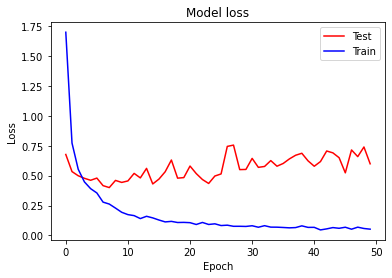

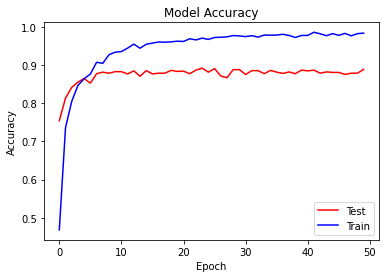

Best Accuracy:89.20%


In [25]:
accs = []
class AlexNet5(nn.Module):
    def __init__(self, num_classes: int = 15, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class lastLayer(nn.Module):
    def __init__(self, pretrained):
        super(lastLayer, self).__init__()
        self.pretrained = pretrained
        self.last = nn.Sequential(nn.ReLU(inplace=True),
                                           nn.Linear(4096, 15))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.last(x)
        return x


net = AlexNet5()


state_dict = load_state_dict_from_url(model_urls["alexnet"], progress=True)
net.load_state_dict(state_dict,strict=False)
net = lastLayer(net).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)


epochs = 50
from time import time
accs_train = []
loss_train = []
accs_test = []
loss_test = []
for e in range(epochs):
    start_time = time()
    accs_train,loss_train = train_epoch(net, criterion, optimizer, trainloader,accs_train,loss_train)
    accs_test,loss_test = eval_epoch(net, criterion, valloader,accs_test,loss_test)

    end_time = time()

    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

plt.plot(np.array(loss_test), 'r')
plt.plot(np.array(loss_train), 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('loss5.jpg')
plt.show()

plt.plot(np.array(accs_test), 'r')
plt.plot(np.array(accs_train), 'b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'])
plt.savefig('acc5.jpg')
plt.show()

torch.save(net.state_dict(), 'alexNet5.pth')
print(f'Best Accuracy:{max(accs_test) * 100.:.2f}%')